# Training and applying a XGBoost model in Geo Engine

In this notebook we train a toy machine learning model inside the Geo Engine and apply it using the XgboostOperator.

This example requires Geo Engine Pro.

In [23]:
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from matplotlib.colors import ListedColormap

import geoengine as ge
from geoengine import StoredDataset
from geoengine.colorizer import Colorizer
from geoengine.workflow_builder.operators import GdalSource, Expression
from geoengine.tasks import Task, TaskId, CompletedTaskStatusInfo
import requests as re
import json

ge.initialize(
    "http://localhost:3030/api", ("admin@localhost", "adminadmin")
)
session = ge.get_session()

## Train the model

In [24]:
source_a = GdalSource("ndvi")

source_b = GdalSource("land_cover")

label = Expression("if B >=1 && B <= 5 { 0 } else { 1 }", {"a": source_a, "b": source_b}, output_type = "U8")

ml_request = {
	"params": {
		"type": "xgboost",
		"noDataValue": -1000.0,
		"trainingConfig": {
			"eta": "0.75",
			"max_depth": "10",
			"refresh_leaf": "true",
			"tree_method": "hist",
			"objective": "multi:softmax",
			"num_class": "3" # 2 + no data ???
		},
		"featureNames": ["a", "b"],
		"labelNames": ["target"],
		"aggregateVariant": "simple",
		"memoryLimit": 1024
	},
	"inputWorkflows": [ 
        source_a.to_workflow_dict(),
        source_b.to_workflow_dict(),
    ],
	"labelWorkflows": [
        label.to_workflow_dict()
    ],
	"query": {
		"spatialBounds": {
			"lowerLeftCoordinate": {
				"x": -180.0,
				"y": -90.0
			},
			"upperRightCoordinate": {
				"x": 180.0,
				"y": 90.0
			}
		},
		"timeInterval": {
			"start": 1388534400000, # 2014-01-01
			"end": 1388534400000
		},
		"spatialResolution": {
			"x": 0.1,
			"y": 0.1
		}
	},
	"modelType": "XGBoost"
}

response = re.post("http://localhost:3030/api/ml/train", json=ml_request, headers=session.auth_header)

task = Task(TaskId.from_response(response.json()))

task_status_info: CompletedTaskStatusInfo = task.wait_for_finish(5, print_status=True)

ml_model_id = task_status_info.info["modelId"]

ml_model_id

status=running, time_started=2023-09-01 13:50:18.712000+00:00, pct_complete=0.00%, estimated_time_remaining=? (± ?), info=None, task_type=create-ml-model, description=Training ML model with id: 3554d01a-4223-4a89-b911-62413b9006a0
status=running, time_started=2023-09-01 13:50:18.712000+00:00, pct_complete=0.00%, estimated_time_remaining=? (± ?), info=None, task_type=create-ml-model, description=Training ML model with id: 3554d01a-4223-4a89-b911-62413b9006a0
status=running, time_started=2023-09-01 13:50:18.712000+00:00, pct_complete=0.00%, estimated_time_remaining=? (± ?), info=None, task_type=create-ml-model, description=Training ML model with id: 3554d01a-4223-4a89-b911-62413b9006a0
status=completed, time_started=2023-09-01 13:50:18.712000+00:00, info={'modelId': '3554d01a-4223-4a89-b911-62413b9006a0'}, time_total=00:00:22, task_type=create-ml-model, description=Training ML model with id: 3554d01a-4223-4a89-b911-62413b9006a0


'3554d01a-4223-4a89-b911-62413b9006a0'

## Plot result

In [25]:
workflow = {
    "type": "Raster",
    "operator": {
        "type": "XgboostOperator",
        "params": {
            "modelId": ml_model_id,
            "noDataValue": -1000.0,
        },
        "sources": {
            "rasters": [
                source_a.to_dict(),
                source_b.to_dict(),
            ]
        }
    },
}

workflow = ge.register_workflow(workflow)
workflow

2c0a52e6-a6eb-59ae-ae22-626043814b15

In [26]:
time = datetime.strptime('2014-05-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

data = workflow.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
        ge.TimeInterval(time, time),
        ge.SpatialResolution(0.1, 0.1)
        )
    )

data

/home/michael/git/geoengine-python/env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


<xarray.DataArray (band: 1, y: 1800, x: 3600)>
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * y            (y) float64 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:4326
    res:           (0.1, -0.1)
    transform:     | 0.10, 0.00,-180.00|\n| 0.00,-0.10, 90.00|\n| 0.00, 0.00,...

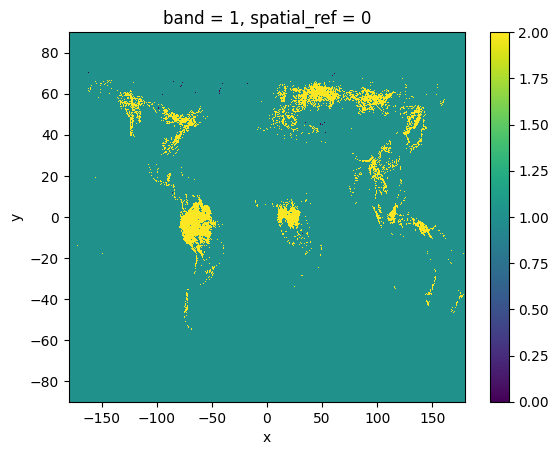

In [27]:
data.plot()